In [6]:
import numpy as np
import poppy
if poppy.accel_math._USE_CUPY:
    import cupy as cp
    xp = cp
else:
    xp = np

from scipy.integrate import simpson

import astropy.units as u
from astropy.io import fits
from IPython.display import display, clear_output
import time
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import warnings
warnings.filterwarnings("ignore")

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import ray
# ray.init(log_to_driver=False)

import cgi_phasec_poppy as cgi
import misc_funs as misc

import emccd_detect

from importlib import reload
reload(cgi)

wavelength_c = 575e-9*u.m
iwa = 2.8
owa = 9.7

data_dir = cgi.data_dir

dm1_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

In [2]:
cgi.BBCGI

cgi_phasec_poppy.bbcgi.BBCGI

<Quantity 1.10962791e-17 sr>

<Quantity [400.      , 400.030003, 400.060006, ..., 699.939994, 699.969997,
           700.      ] nm>

<Quantity [8.13231992e-32, 8.13300514e-32, 8.13369010e-32, ...,
           6.99472313e-32, 6.99430378e-32, 6.99388443e-32] J m2 / (nm5 s sr)>

Unit("J / (m2 nm s)")

Text(0, 0.5, '$W/m^2/sr/nm$')

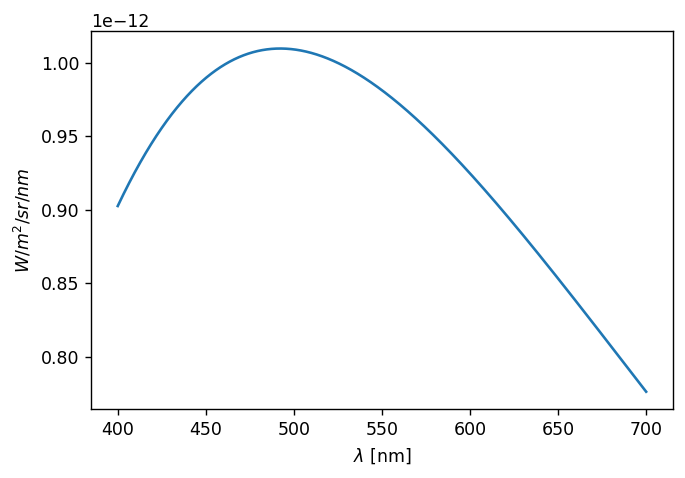

In [7]:
from astropy.constants import h, c, k_B, R_sun

pupil_diam = 2.36*u.m
d = (14.06*u.parsec).to(u.m)
R_uma47 = 1.172*R_sun

SA_ap = np.pi*(((pupil_diam/d)*u.radian)**2).to(u.sr)
SA_uma47 = np.pi * (R_uma47/d)**2 * u.sr
display(SA_uma47)

T = 5887*u.K

lambdas = np.linspace(400, 700, 10000)*u.nm
display(lambdas)

spec = 2*np.pi*h*c**2/(lambdas**5)/(np.exp(h*c/(k_B*T*lambdas)) - 1)/u.sr
display(spec)

spec = spec.to(u.J/u.s/u.sr/u.m**2/u.nm) * SA_uma47
display(spec.unit)

fig,ax = plt.subplots(1,1,dpi=125)
ax.plot(lambdas, spec)
ax.set_xlabel('$\lambda$ [nm]')
ax.set_ylabel('$W/m^2/sr/nm$')

In [8]:
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
inds = np.where((lambdas>minlam)&(lambdas<maxlam))

wave_range = lambdas[inds].value
spec_range = spec[inds].value
display(wave_range)

flux = simpson(spec_range, wave_range)*u.J/u.s/u.m**2 # integrate over the wave band

E = h*c/wavelength_c.to(u.m) / u.photon # energy of the photon for this wavelength
flux /= E # convert to photons/s/m**2
display(flux)

array([546.26462646, 546.29462946, 546.32463246, ..., 603.66036604,
       603.69036904, 603.72037204])

<Quantity 1.5871732e+08 ph / (m2 s)>

In [9]:

nlam = 3
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

del_waves = wavelengths[1]-wavelengths[0]
fluxes = []
for i in range(nlam):
    wave = wavelengths[i].to(u.nm)
    min_wave = wave-del_waves/2
    max_wave = wave+del_waves/2
    inds = np.where((lambdas>min_wave)&(lambdas<max_wave))
    
    wave_range = lambdas[inds].value
    spec_range = spec[inds].value
    
    fluxes.append(simpson(spec_range, wave_range)*u.J/u.s/u.m**2) # integrate over the wave band
    
    E = h*c/wave.to(u.m) / u.photon # energy of the photon for this wavelength
    fluxes[i] /= E # convert to photons/s/m**2
    
display(fluxes)

[<Quantity 77696501.68104902 ph / (m2 s)>,
 <Quantity 79389091.10906622 ph / (m2 s)>,
 <Quantity 80316993.40983412 ph / (m2 s)>]

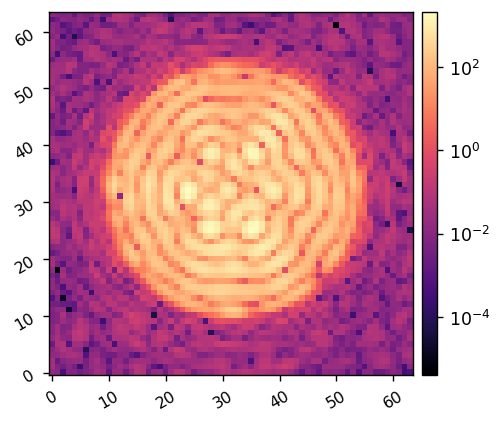

In [10]:
reload(cgi)
hlc = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=fluxes[2])

hlc.set_dm1(dm1_flat)
hlc.set_dm2(dm2_flat)

im = hlc.snap()
misc.imshow1(im, lognorm=True)

In [6]:
reload(cgi)
rayCGI = ray.remote(cgi.CGI)

mode_settings = {'cgi_mode':'hlc',
                 'use_pupil_defocus':True, 
                 'use_opds':True,
                 'exp_time':5}

actors = []
for i in range(nlam):
    actors.append(rayCGI.options(num_gpus=1/nlam).remote(wavelength=wavelengths[i], source_flux=fluxes[i], **mode_settings))


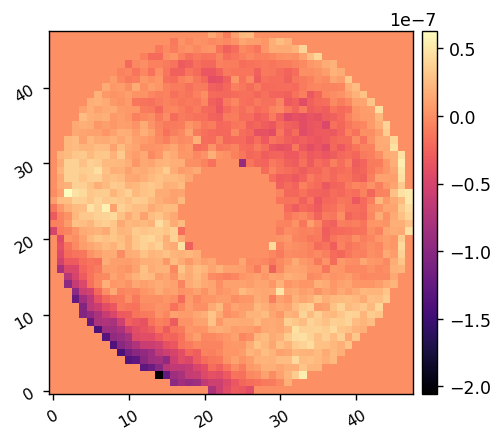

In [15]:
reload(cgi)
reload(cgi.bbcgi)
hlc10 = cgi.BBCGI(actors)

hlc10.set_dm1(dm1_flat)
misc.imshow1(hlc10.get_dm1())

In [16]:
psfs = hlc10.calc_psfs(quiet=False)

PSFs calculated in 0.687s.


(CGI pid=105890) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105890) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105888) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105888) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105889) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105889) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.


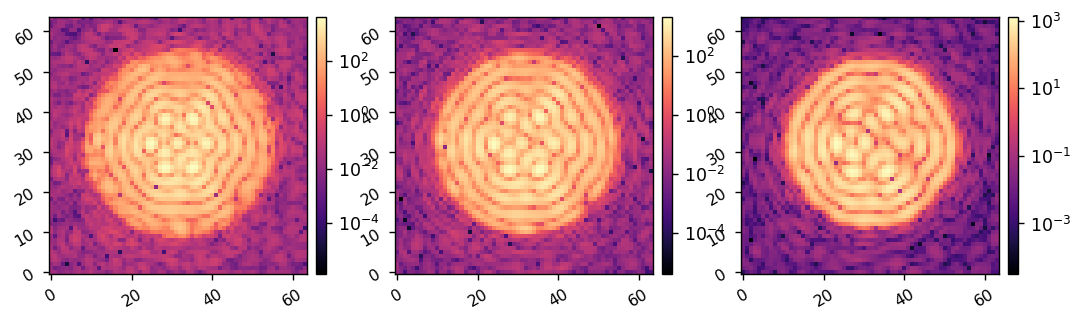

In [19]:
misc.imshow3(xp.abs(psfs[0])**2, xp.abs(psfs[1])**2, xp.abs(psfs[2])**2, lognorm=True)

(CGI pid=105890) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105890) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105888) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105888) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105889) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=105889) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.


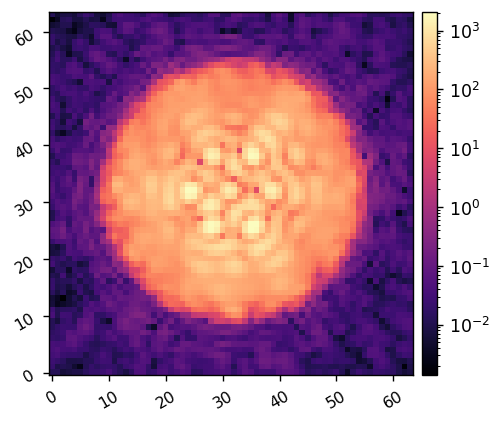

In [20]:
hlc10.set_dm1(dm1_flat)
hlc10.set_dm2(dm2_flat)

im = hlc10.snap()
misc.imshow1(im, lognorm=True)

In [11]:
def snap_broadband_im(actors, plot=False, return_all=True):
    pending_ims = []
    for i in range(len(actors)):
        actors[i].set_dm1.remote(dm1_flat) # set the DM state for each actor in this loop
        actors[i].set_dm2.remote(dm2_flat)
        
        future_ims = actors[i].snap.remote()
        pending_ims.append(future_ims)
    ims = xp.array(ray.get(pending_ims))
    
    im = xp.sum(ims, axis=0)/len(actors) # average each of the 
    
    clear_output(wait=True)
    if plot:
        for i in range(len(actors)):
            misc.imshow1(ims[i], lognorm=True,)
            
    if return_all:
        return im, ims
    else:
        return im

# Without EMCCD

(CGI pid=67048) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=67048) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=67050) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.
(CGI pid=67050) After resampling, optic phasor shape (636, 636) is smaller than input wavefront (1024, 1024); will zero-pad the rescaled array.


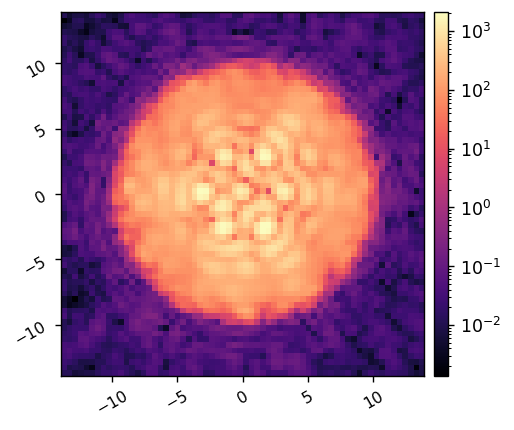

In [12]:
im, ims = snap_broadband_im(actors, plot=False)
misc.imshow1(im, lognorm=True, pxscl=hlc.psf_pixelscale_lamD)

# Define the EMCCD parameters

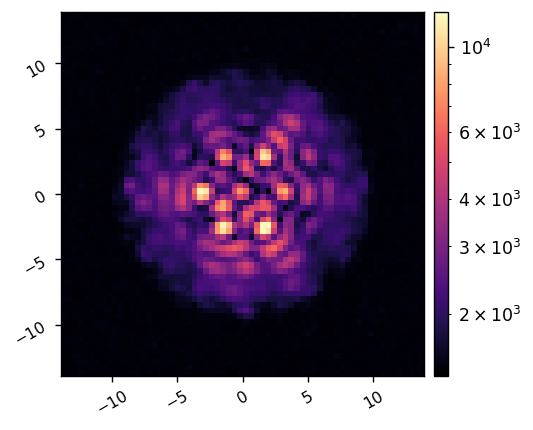

In [26]:
from emccd_detect.emccd_detect import EMCCDDetect, emccd_detect

meta_path = Path('/home/u21/kianmilani/src/emccd_detect/emccd_detect', 'emccd_detect', 'util', 'metadata.yaml')

dark_current = 0.05*u.electron/u.pix/u.hour

frametime = 10
EMCCD = EMCCDDetect(
    em_gain=4.,
    full_well_image=50000.,  # e-
    full_well_serial=90000.,  # e-
    dark_current=dark_current.to_value(u.electron/u.pixel/u.second),  # e-/pix/s
    cic=0.016,  # e-/pix/frame
    read_noise=120.,  # e-/pix/frame
    bias=10000.,  # e-
    qe=0.9,
    cr_rate=5.,  # hits/cm^2/s
    pixel_pitch=13e-6,  # m
    eperdn=7.,
    nbits=14,
    numel_gain_register=604,
    meta_path=meta_path,
)

flux_map = im.get()

frame = EMCCD.sim_sub_frame(flux_map, frametime)
misc.imshow1(frame, lognorm=True, pxscl=hlc.psf_pixelscale_lamD)